# Plot Price Prediction

## Imports & Basic Setup

In [1]:
# Common imports
import sys
import os
import numpy as np
import pandas as pd

import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# To plot pretty figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Define directory to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# function to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# To get same results during each run
np.random.seed(42)

# Ignoring useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

## Dataset Setup

In [3]:
df = pd.read_csv('dataset.csv')
df.shape

(43628, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 18 columns):
id                  43628 non-null int64
disc                43628 non-null object
region              43628 non-null object
cityID              43628 non-null int64
area                43628 non-null float64
price               43628 non-null int64
Lat                 43628 non-null float64
Lng                 43628 non-null float64
bank                43628 non-null int64
mosque              43628 non-null int64
bus                 43628 non-null int64
park                43628 non-null int64
department_store    43628 non-null int64
school              43628 non-null int64
supermarket         43628 non-null int64
cemetary            43628 non-null int64
hospital            43628 non-null int64
restaurant          43628 non-null int64
dtypes: float64(3), int64(13), object(2)
memory usage: 6.0+ MB


In [5]:
# some region names end with comma, removing those commas
df['region'] = df['region'].str.strip(',')
df.shape

(43628, 18)

In [6]:
def cleanData():
    global df
    # Removing outliers
    indexNames = df[ (df['price'] >= 250000000 )].index
    df.drop(indexNames , inplace=True)
    print(df.shape)
    indexNames = df[(df['price'] <= 10000)].index
    df.drop(indexNames , inplace=True)
    print(df.shape)
    indexNames = df[(df['area']>= 1000)].index
    df.drop(indexNames , inplace=True)
    print(df.shape)
    indexNames = df[(df['area'] <= 3 )].index
    df.drop(indexNames , inplace=True)
    print(df.shape)
    
    # Removing places with the same latitude and longitude
    df.drop_duplicates(subset=['Lat','Lng'],keep='first',inplace = True)
    print(df.shape)

In [7]:
cleanData()
df.head()

(43591, 18)
(43591, 18)
(43590, 18)
(43587, 18)
(2158, 18)


,id,disc,region,cityID,area,price,Lat,Lng,bank,mosque,bus,park,department_store,school,supermarket,cemetary,hospital,restaurant
0,2,7 Marla Plot for Sale.,B-17,1,7.62400,2300000,33.669341,72.844890,1,1,0,0,0,1,1,1,1,1
16,41,5 Marla Residential Land for Sale in Islamabad...,Top City-1,1,5.44504,1000000,33.586108,72.866789,1,1,0,1,0,1,1,1,1,1
29,54,600 Square Yard Plot for Sale,F-16,1,21.60000,5500000,33.656936,72.888470,1,0,0,0,0,1,1,1,1,1
48,74,200 Square Yards Plot for Sale,Faisal Hills,1,7.20000,2185000,33.729388,73.093146,1,1,1,1,1,1,1,1,1,1
57,88,10 Marla Plot for Sale,Bahria Town,1,10.89200,9500000,33.692555,73.219032,1,1,0,1,0,1,1,1,1,1


In [8]:
df.describe()
# remaining dataset entries are 2158. 

,id,cityID,area,price,Lat,Lng,bank,mosque,bus,park,department_store,school,supermarket,cemetary,hospital,restaurant
count,2158.000000,2158.000000,2158.000000,2.158000e+03,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000
mean,27620.110287,1.963855,18.053462,1.529253e+07,32.572422,73.643578,0.863763,0.501854,0.246525,0.495366,0.401761,0.994903,0.995366,0.981928,0.988879,0.982854
std,18338.542450,0.999578,30.080210,2.349205e+07,1.114469,0.671395,0.343120,0.500112,0.431087,0.500094,0.490368,0.071230,0.067931,0.133244,0.104894,0.129844
min,2.000000,1.000000,3.267000,3.300000e+05,24.993758,67.307440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15779.500000,1.000000,7.623040,4.000000e+06,31.455539,73.043821,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,25207.500000,1.000000,10.890040,7.575000e+06,33.521323,73.218711,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,36617.250000,3.000000,21.780000,1.650000e+07,33.632623,74.284503,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,66744.000000,3.000000,784.080000,2.300000e+08,33.744962,74.499221,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Digging the Dataset and Visualizing to Gain Insights

### Histograms of Dataset Attributes

Saving figure attribute_histogram_plots


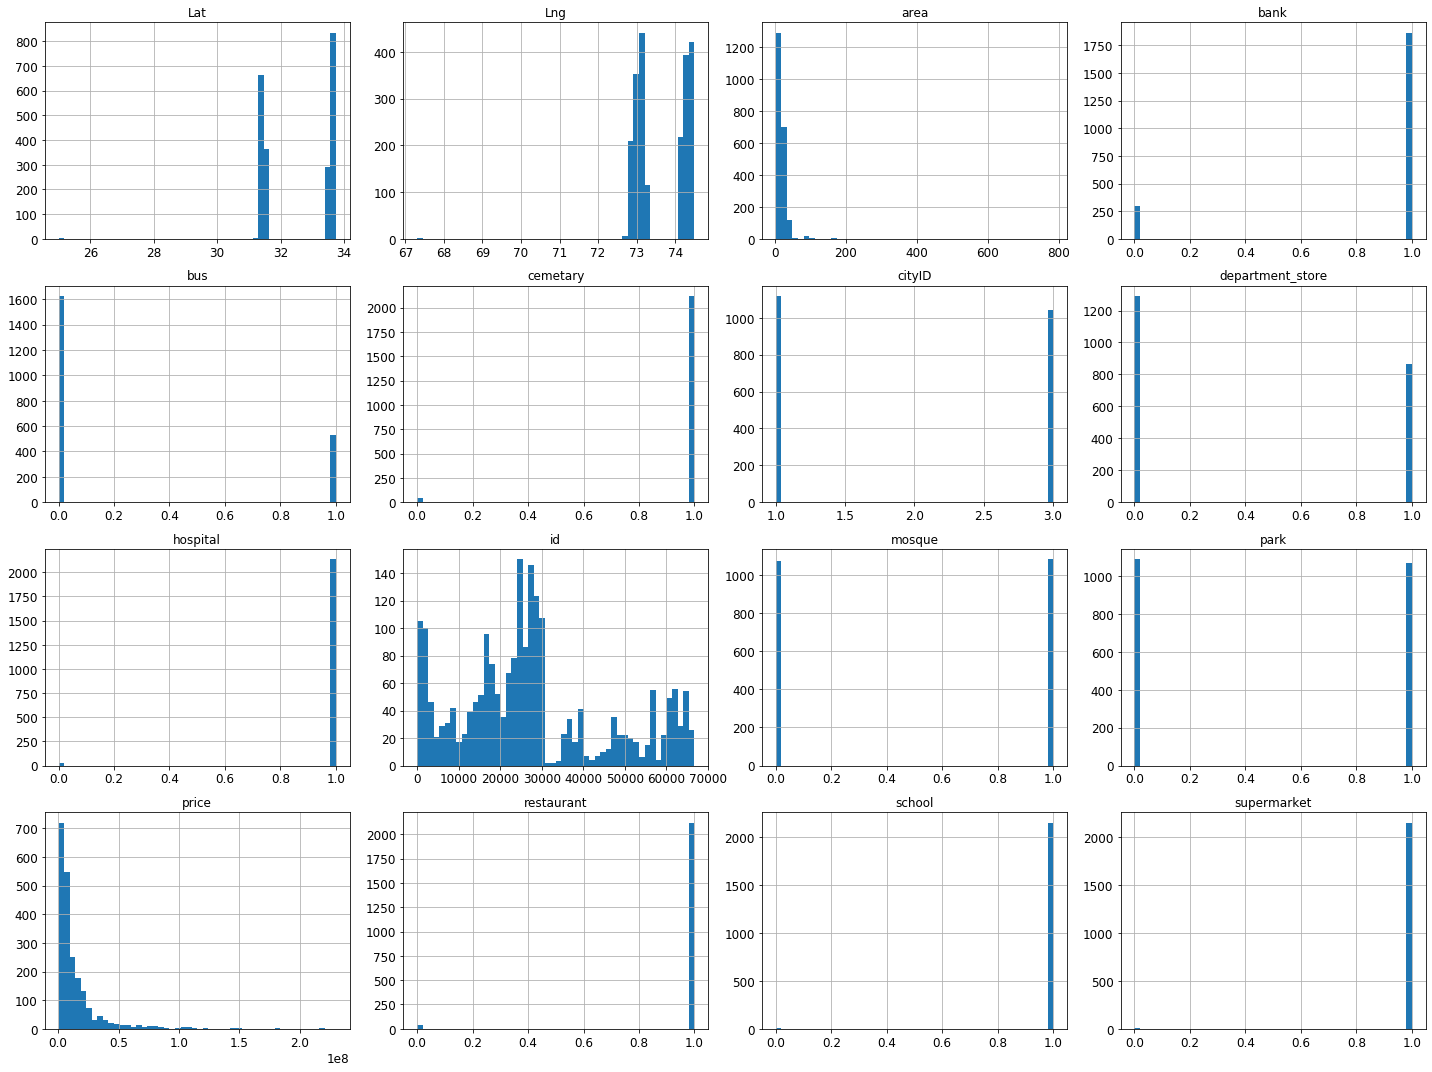

In [9]:
df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

**Attribute Histograms without removing the duplicate (latitude, longitude) records:**
![attribute_histogram_plots_without_removing_duplicates](images/attribute_histogram_plots_without_removing_duplicates.png)

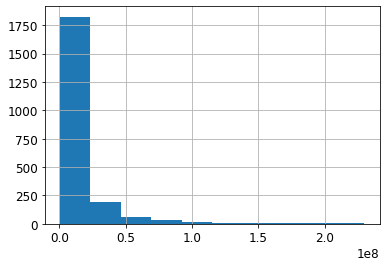

In [10]:
df['price'].hist()

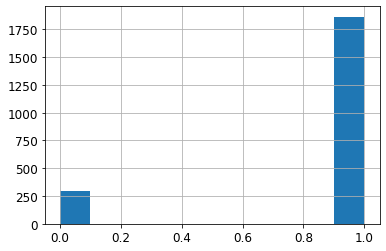

In [11]:
df['bank'].hist()

#### Observations and deductions from the Attribute Histograms
- **Most of variables are not continuous**. Binary variables are not suitable for predicting a continuous variable. So, those values must be replaced with suitable values. For example, **distance to bank, restaurant, school and other places can be added to the dataset.**

- Secondly, added distances (or other important attributes) can be converted into the categories (a certain range of the distances) for **stratified sampling**. *Stratified sampling can decrease the sampling bias*. Because, stratified sampling arranges all the dataset into categories. Then, we can choose equal number of samples from each category. **This technique will minimize the sampling bias.** Purely random sampling (which is being used) produces the skewed results.

- **Useless Attributes**: *Cemetery, hospital, restaurant, school and supermarket* are present in almost all the records. So, these will not be helpful in predictive models. 
    
    To balance the dataset, records with absence of these places near them should be added in the dataset. Alternatively, current values (1 or 0) should be replaced with distances to respective places.

- **Remaining potential attributes**: *Area, bank, bus, mosque, department_store and park* may prove helpful in predictive models. More attributes should be added for the better results.



### Visualizing Attributes w.r.t Price

#### Area

Saving figure price_vs_area_scatterplot


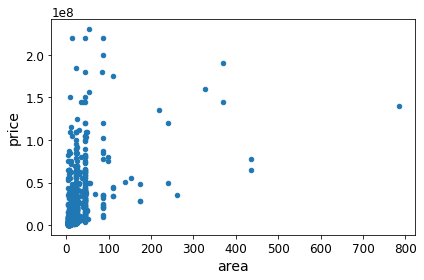

In [12]:
df.plot(kind="scatter", x="area", y="price",
             alpha=1)
save_fig("price_vs_area_scatterplot")

### Preprocessing Dataset

In [13]:
# converting to string variable "region" to numerical variables 
df['region'] = pd.Categorical(df['region'])

dfDummies = pd.get_dummies(df['region'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)

### Location Scatter Plots

Saving figure overall_scatter_plot


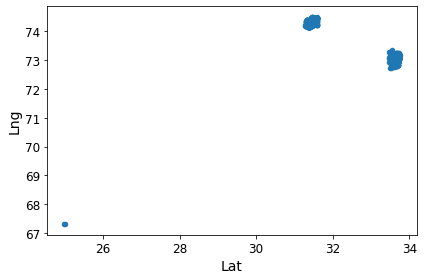

In [14]:
df.plot(kind="scatter", x="Lat", y="Lng")
save_fig("overall_scatter_plot")


W1201 15:39:05.701071  6008 legend.py:1282] No handles with labels found to put in legend.


Saving figure housing_prices_scatterplot


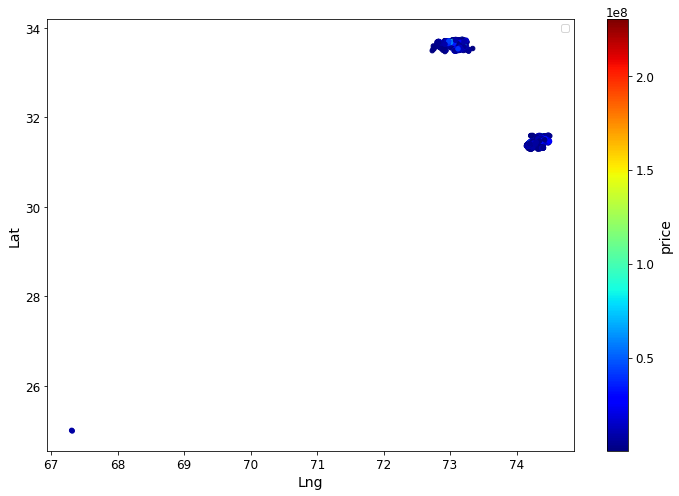

In [15]:
df.plot(kind="scatter", x="Lng", y="Lat", alpha=1,
    figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

#### Implications of scatter plots:
- Dataset points are very closely placed. So, most of the entries are from the same towns/colonies or nearly situated towns/colonies. **To predict the price differences within the towns/colonies**, we need attributes which count to differences in prices within same town, colony or city. Currently, such attributes in the dataset are: area, bank, bus, mosque and park. Only area is a continuous variable here. Problems with the non-continuous variables are discussed earlier in "Attributes Histograms" section.

- **To better predict price differences in cities**, attributes which count to difference of prices in cities should present in the dataset. There is not even a single such attribute in the dataset. Possible new attributes to differentiate cities can be can be popular, presence of people of certain social class (can be differentiated on the basis of their income, job etc), presence of industries, number of malls, number of cinemas, number of parks, etc.

### Correlation Matrix and Plots

Saving figure correlation_matrix_heatmap


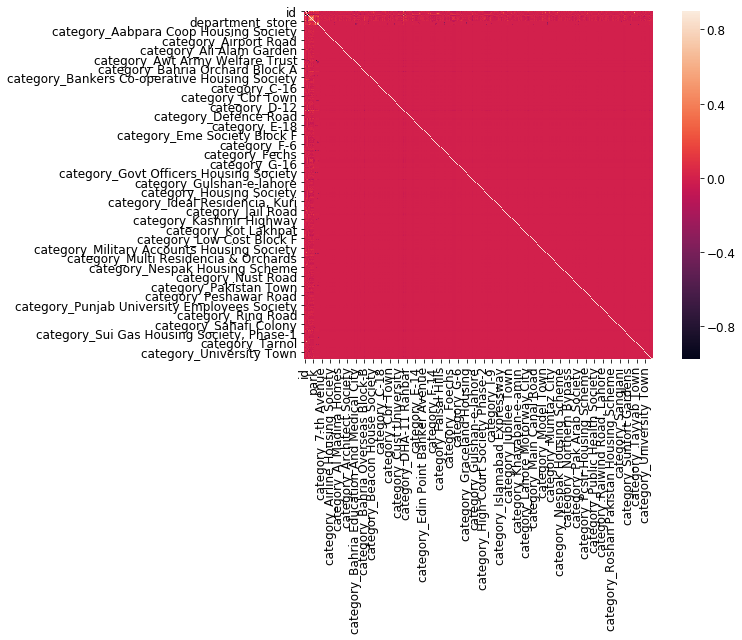

In [16]:
corr_matrix = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True)
save_fig("correlation_matrix_heatmap")

**Correlation matrix heatmap without converting region attribute to categorical variable:**
![correlation matrix heatmap without categorical region variable](images/correlation_matrix_heatmap_without_categorical_region_variable.png)

**Correlation Matrix without Category Variables**

![correlation_matrix_without_categorical_region_variable](images/correlation_matrix_without_categorical_region_variable.png)

In [17]:
# Run this to generate full correlation matrix. It needs significant processing and memory. 
# Chrome may become unresponsive due to the amount of output data
# corr_matrix.style.background_gradient(cmap='coolwarm', axis=None)

In [18]:
corr_matrix["price"].sort_values(ascending=False)

price                                  1.000000
area                                   0.462654
category_F-7                           0.282082
category_F-8                           0.244955
category_E-7                           0.196835
category_Emporium Mall                 0.187667
category_F-10                          0.174314
category_F-11                          0.173792
category_Peco Road                     0.169332
category_DHA                           0.157106
category_Japan Road                    0.132662
category_Model Town                    0.128494
category_Kalma Chowk Lahore            0.118910
category_Tarlai                        0.114327
bank                                   0.084902
category_Ali Pur                       0.078118
category_F-6                           0.077428
department_store                       0.075604
Lng                                    0.075235
category_F-9                           0.069864
category_Koral Chowk                   0

#### Deductions from the correlations
- As expected, there is a strong correlation between the price and area.
- Some category variables does not have a correlation with the prices. Because, the area and other attributes are not being considered in correlation calculation.
- *Correlation between previously separated potential attributes (area, bank, bus, mosque, park) is insignificant*. **This points to possibility of defects in the dataset collection, selection of dataset attributes and default attribute values/types.** We can't certainly say that the correlation doesn't exist because there are other attributes affecting the price at the same time. For example, decrease in price is not significant due to absence of bank if the area of plot is high.
    
    **Presence of defects can be pointed out by** checking correlation between pair of attributes with the price. **For example**, *correlation between (mosque, area) and price should be checked*. One attribute in the pair should be area because it is most influential attribute in the dataset.


## Preprocessing Dataset for Predictive Models

In [19]:
del_col_count = 4
X = df.drop(columns=['price','id','disc','region'])
Y = df[['price']]

In [20]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [21]:
X_scale

array([[0.        , 0.00558008, 0.99135876, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00278945, 0.98184766, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02347937, 0.98994124, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.05160391, 0.73929733, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.00976295, 0.73383047, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.00278945, 0.74342956, ..., 0.        , 0.        ,
        0.        ]])

In [22]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [23]:
X.head()

,cityID,area,Lat,Lng,bank,mosque,bus,park,department_store,school,...,category_Uet Housing Society,category_University Road,category_University Town,category_Valencia Housing Society,category_Valencia Housing Society Block A-1,category_Vital Homes Housing Scheme,category_Walton Road,category_Wapda Town,category_Zaraj Housing Scheme,category_Zone-5
0,1,7.62400,33.669341,72.844890,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
16,1,5.44504,33.586108,72.866789,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
29,1,21.60000,33.656936,72.888470,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
48,1,7.20000,33.729388,73.093146,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
57,1,10.89200,33.692555,73.219032,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
Y.head()

,price
0,2300000
16,1000000
29,5500000
48,2185000
57,9500000


In [25]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

## Predictive ML Models

### Defining Models

#### Model 1 - Dense Layers

In [26]:
model_1 = Sequential([
    Dense(len(list(df)) - del_col_count, activation='relu', input_shape=(len(list(df)) - del_col_count,)),
    Dense(500, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1),
])

In [27]:
model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

#### Model 2 - 3 Dense Layers

In [28]:
model_2 = Sequential([
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(len(list(df)) - del_col_count,)),
    Dropout(0.3),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=regularizers.l2(0.01)),
])

In [29]:
model_2.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_squared_error'])

### Training

In [30]:
# Easily keep track of loss values by counting number of 10s.
# returns a "num" and "count" of 10s
# get actual number by: num * 10^count
def countTens(num):
    count = 0
    while num >= 10:
        num = num/10.0
        count += 1
    # return reduced number too
    return (num, count)

#### Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Decision Tree Regression

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_model = DecisionTreeRegressor(random_state=42)
tree_reg_model.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

#### Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

forest_reg_model = RandomForestRegressor(n_estimators=150, random_state=42)
forest_reg_model.fit(X_train, Y_train)

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [58]:
# Using Grid Search for Optimal Hypyerparameters
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [50, 70, 100, 150, 200], 'max_features': [2, 4, 6, 8, 10, 12]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [50, 70, 100, 150, 200], 'max_features': [2, 3, 4, 8, 10, 12]},
  ]

forest_reg_model = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg_model, param_grid, cv=12,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, Y_train)

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\sklearn\model_selection\_validation.py:514:

GridSearchCV(cv=12, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8, 10

In [59]:
price_predictions = grid_search.predict(X_train)
forest_reg_mse = mean_squared_error(price_predictions, Y_train)
forest_reg_rmse = np.sqrt(forest_reg_mse)
reduced_num, ten_count = countTens(forest_reg_rmse)
print("RMSE on training set using Forest Tree Regression is: " + str(reduced_num) + " * 10^" + str(ten_count))

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

#### Deep Learning Model 1

In [102]:
hist = model_1.fit(X_train, Y_train,
          batch_size=32, epochs=1000,
          validation_data=(X_val, Y_val))

Train on 1726 samples, validate on 216 samples
Epoch 1/1000
1726/1726 [==============================] - 1s 806us/sample - loss: 831902638043169.2500 - mean_squared_error: 831902684545024.0000 - val_loss: 594396421437667.5000 - val_mean_squared_error: 594396428894208.0000
Epoch 2/1000
1726/1726 [==============================] - 0s 98us/sample - loss: 828949228689339.2500 - mean_squared_error: 828949290549248.0000 - val_loss: 585798088140269.0000 - val_mean_squared_error: 585798105694208.0000
Epoch 3/1000
1726/1726 [==============================] - 0s 94us/sample - loss: 801758647251205.1250 - mean_squared_error: 801758590795776.0000 - val_loss: 533185677200952.8750 - val_mean_squared_error: 533185662287872.0000
Epoch 4/1000
1726/1726 [==============================] - 0s 112us/sample - loss: 714507562991862.8750 - mean_squared_error: 714507538137088.0000 - val_loss: 413004964881294.2500 - val_mean_squared_error: 413004927598592.0000
Epoch 5/1000
1726/1726 [===========================

Epoch 37/1000
1726/1726 [==============================] - 0s 98us/sample - loss: 478267153177551.3750 - mean_squared_error: 478267257651200.0000 - val_loss: 216056446427439.4062 - val_mean_squared_error: 216056467554304.0000
Epoch 38/1000
1726/1726 [==============================] - 0s 103us/sample - loss: 477225915173151.1250 - mean_squared_error: 477225962962944.0000 - val_loss: 215775231548529.7812 - val_mean_squared_error: 215775247859712.0000
Epoch 39/1000
1726/1726 [==============================] - 0s 104us/sample - loss: 477606747522182.0625 - mean_squared_error: 477606738657280.0000 - val_loss: 214197996617728.0000 - val_mean_squared_error: 214197988229120.0000
Epoch 40/1000
1726/1726 [==============================] - 0s 105us/sample - loss: 477636102848360.0625 - mean_squared_error: 477636065230848.0000 - val_loss: 214678464704360.2812 - val_mean_squared_error: 214678470918144.0000
Epoch 41/1000
1726/1726 [==============================] - 0s 110us/sample - loss: 4772036853

1726/1726 [==============================] - 0s 106us/sample - loss: 465537630821896.8750 - mean_squared_error: 465537578565632.0000 - val_loss: 209886759771856.5938 - val_mean_squared_error: 209886763810816.0000
Epoch 110/1000
1726/1726 [==============================] - 0s 120us/sample - loss: 463711322770701.3125 - mean_squared_error: 463711277940736.0000 - val_loss: 209602598316714.6562 - val_mean_squared_error: 209602591326208.0000
Epoch 111/1000
1726/1726 [==============================] - 0s 98us/sample - loss: 463902078083613.0625 - mean_squared_error: 463902068441088.0000 - val_loss: 210019216824244.1562 - val_mean_squared_error: 210019203153920.0000
Epoch 112/1000
1726/1726 [==============================] - 0s 100us/sample - loss: 463173380508068.0000 - mean_squared_error: 463173400395776.0000 - val_loss: 209196260825012.1562 - val_mean_squared_error: 209196247154688.0000
Epoch 113/1000
1726/1726 [==============================] - 0s 102us/sample - loss: 464230232885630.1250

1726/1726 [==============================] - 0s 87us/sample - loss: 456151819804282.8125 - mean_squared_error: 456151799955456.0000 - val_loss: 206378359625652.1562 - val_mean_squared_error: 206378362732544.0000
Epoch 146/1000
1726/1726 [==============================] - 0s 87us/sample - loss: 455355823119273.3750 - mean_squared_error: 455355754610688.0000 - val_loss: 206369381174234.0625 - val_mean_squared_error: 206369403699200.0000
Epoch 147/1000
1726/1726 [==============================] - 0s 114us/sample - loss: 455145533528052.1250 - mean_squared_error: 455145603203072.0000 - val_loss: 206242299044750.2188 - val_mean_squared_error: 206242282733568.0000
Epoch 148/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 454865553170099.7500 - mean_squared_error: 454865557913600.0000 - val_loss: 206148419181074.9688 - val_mean_squared_error: 206148414210048.0000
Epoch 149/1000
1726/1726 [==============================] - 0s 95us/sample - loss: 454793702827683.1250 -

1726/1726 [==============================] - 0s 90us/sample - loss: 432502057108253.3750 - mean_squared_error: 432502032302080.0000 - val_loss: 202776481181544.2812 - val_mean_squared_error: 202776495783936.0000
Epoch 218/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 432172088150682.8125 - mean_squared_error: 432172091572224.0000 - val_loss: 200995899402315.8438 - val_mean_squared_error: 200995896295424.0000
Epoch 219/1000
1726/1726 [==============================] - 0s 107us/sample - loss: 432102545501690.6875 - mean_squared_error: 432102566789120.0000 - val_loss: 201511467754989.0312 - val_mean_squared_error: 201511476920320.0000
Epoch 220/1000
1726/1726 [==============================] - 0s 94us/sample - loss: 431016702133761.7500 - mean_squared_error: 431016711815168.0000 - val_loss: 198728019966786.3750 - val_mean_squared_error: 198728019345408.0000
Epoch 221/1000
1726/1726 [==============================] - 0s 90us/sample - loss: 431697875601068.6250 -

1726/1726 [==============================] - 0s 90us/sample - loss: 393432946704991.5000 - mean_squared_error: 393432929402880.0000 - val_loss: 198684245258695.1250 - val_mean_squared_error: 198684247588864.0000
Epoch 290/1000
1726/1726 [==============================] - 0s 86us/sample - loss: 392947707475965.6250 - mean_squared_error: 392947765870592.0000 - val_loss: 201902711344696.8750 - val_mean_squared_error: 201902721597440.0000
Epoch 291/1000
1726/1726 [==============================] - 0s 91us/sample - loss: 391337517120472.8750 - mean_squared_error: 391337522233344.0000 - val_loss: 198048925487862.5312 - val_mean_squared_error: 198048911196160.0000
Epoch 292/1000
1726/1726 [==============================] - 0s 101us/sample - loss: 390904891313725.0625 - mean_squared_error: 390904938496000.0000 - val_loss: 201504834385540.7188 - val_mean_squared_error: 201504833142784.0000
Epoch 293/1000
1726/1726 [==============================] - 0s 109us/sample - loss: 390379891079108.6875 -

Epoch 361/1000
1726/1726 [==============================] - 0s 86us/sample - loss: 336617614564417.2500 - mean_squared_error: 336617592061952.0000 - val_loss: 214260877312606.8125 - val_mean_squared_error: 214260869234688.0000
Epoch 362/1000
1726/1726 [==============================] - 0s 87us/sample - loss: 335543100298340.8750 - mean_squared_error: 335543112040448.0000 - val_loss: 212344670072680.2812 - val_mean_squared_error: 212344676286464.0000
Epoch 363/1000
1726/1726 [==============================] - 0s 91us/sample - loss: 334930507599269.2500 - mean_squared_error: 334930475220992.0000 - val_loss: 214969080261290.6562 - val_mean_squared_error: 214969085853696.0000
Epoch 364/1000
1726/1726 [==============================] - 0s 118us/sample - loss: 333808072199817.0625 - mean_squared_error: 333808113025024.0000 - val_loss: 208859305976111.4062 - val_mean_squared_error: 208859293548544.0000
Epoch 365/1000
1726/1726 [==============================] - 0s 87us/sample - loss: 33449243

1726/1726 [==============================] - 0s 105us/sample - loss: 306982386772473.5000 - mean_squared_error: 306982384828416.0000 - val_loss: 213944276333605.9375 - val_mean_squared_error: 213944283168768.0000
Epoch 398/1000
1726/1726 [==============================] - 0s 90us/sample - loss: 304026528985178.1875 - mean_squared_error: 304026474250240.0000 - val_loss: 202107550433280.0000 - val_mean_squared_error: 202107554627584.0000
Epoch 399/1000
1726/1726 [==============================] - 0s 87us/sample - loss: 310634422680631.7500 - mean_squared_error: 310634382098432.0000 - val_loss: 201607696118215.1250 - val_mean_squared_error: 201607694254080.0000
Epoch 400/1000
1726/1726 [==============================] - 0s 108us/sample - loss: 306628258798828.1250 - mean_squared_error: 306628184244224.0000 - val_loss: 215370657528642.3750 - val_mean_squared_error: 215370665295872.0000
Epoch 401/1000
1726/1726 [==============================] - 0s 97us/sample - loss: 304057719025317.5625 -

Epoch 433/1000
1726/1726 [==============================] - 0s 112us/sample - loss: 279211120227020.6875 - mean_squared_error: 279211143069696.0000 - val_loss: 225222546035446.5312 - val_mean_squared_error: 225222565298176.0000
Epoch 434/1000
1726/1726 [==============================] - 0s 96us/sample - loss: 280886329191057.3438 - mean_squared_error: 280886297755648.0000 - val_loss: 224664436410747.2812 - val_mean_squared_error: 224664437653504.0000
Epoch 435/1000
1726/1726 [==============================] - 0s 104us/sample - loss: 278788742577568.4688 - mean_squared_error: 278788726325248.0000 - val_loss: 219878098633917.6250 - val_mean_squared_error: 219878082478080.0000
Epoch 436/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 278838820973201.3438 - mean_squared_error: 278838839869440.0000 - val_loss: 209940152640398.2188 - val_mean_squared_error: 209940148912128.0000
Epoch 437/1000
1726/1726 [==============================] - 0s 101us/sample - loss: 28066

Epoch 469/1000
1726/1726 [==============================] - 0s 99us/sample - loss: 262358186298903.1562 - mean_squared_error: 262358194716672.0000 - val_loss: 213669974444411.2812 - val_mean_squared_error: 213669992464384.0000
Epoch 470/1000
1726/1726 [==============================] - 0s 103us/sample - loss: 261606656954201.8750 - mean_squared_error: 261606659325952.0000 - val_loss: 217657507024440.8750 - val_mean_squared_error: 217657534054400.0000
Epoch 471/1000
1726/1726 [==============================] - 0s 117us/sample - loss: 261111941616285.2188 - mean_squared_error: 261111966334976.0000 - val_loss: 218030032367464.2812 - val_mean_squared_error: 218030021804032.0000
Epoch 472/1000
1726/1726 [==============================] - 0s 99us/sample - loss: 260174539682584.6250 - mean_squared_error: 260174539390976.0000 - val_loss: 223867887438810.0625 - val_mean_squared_error: 223867872215040.0000
Epoch 473/1000
1726/1726 [==============================] - 0s 100us/sample - loss: 261073

Epoch 505/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 254255481811167.0938 - mean_squared_error: 254255436922880.0000 - val_loss: 237673580418389.3438 - val_mean_squared_error: 237673608380416.0000
Epoch 506/1000
1726/1726 [==============================] - 0s 110us/sample - loss: 252354426227582.6562 - mean_squared_error: 252354427355136.0000 - val_loss: 222174656234685.6250 - val_mean_squared_error: 222174648467456.0000
Epoch 507/1000
1726/1726 [==============================] - 0s 115us/sample - loss: 250446706065047.2812 - mean_squared_error: 250446706900992.0000 - val_loss: 226102263706055.1250 - val_mean_squared_error: 226102261841920.0000
Epoch 508/1000
1726/1726 [==============================] - 0s 100us/sample - loss: 249800953043027.0625 - mean_squared_error: 249800985411584.0000 - val_loss: 222450050507055.4062 - val_mean_squared_error: 222450029690880.0000
Epoch 509/1000
1726/1726 [==============================] - 0s 102us/sample - loss: 2528

1726/1726 [==============================] - 0s 112us/sample - loss: 243916937351913.1562 - mean_squared_error: 243916964102144.0000 - val_loss: 234453497971901.6250 - val_mean_squared_error: 234453523759104.0000
Epoch 542/1000
1726/1726 [==============================] - 0s 102us/sample - loss: 244014752992525.3438 - mean_squared_error: 244014724939776.0000 - val_loss: 228390424310215.1250 - val_mean_squared_error: 228390405668864.0000
Epoch 543/1000
1726/1726 [==============================] - 0s 88us/sample - loss: 243726536499000.6875 - mean_squared_error: 243726542700544.0000 - val_loss: 223018064592289.1875 - val_mean_squared_error: 223018039115776.0000
Epoch 544/1000
1726/1726 [==============================] - 0s 87us/sample - loss: 242967795799463.6250 - mean_squared_error: 242967776329728.0000 - val_loss: 221729136953116.4375 - val_mean_squared_error: 221729146273792.0000
Epoch 545/1000
1726/1726 [==============================] - 0s 89us/sample - loss: 243174152275666.6250 -

1726/1726 [==============================] - 0s 124us/sample - loss: 234566968260966.3438 - mean_squared_error: 234566971293696.0000 - val_loss: 222306308602083.5625 - val_mean_squared_error: 222306316058624.0000
Epoch 614/1000
1726/1726 [==============================] - 0s 107us/sample - loss: 233777890709793.5312 - mean_squared_error: 233777888493568.0000 - val_loss: 226387018732885.3438 - val_mean_squared_error: 226387038306304.0000
Epoch 615/1000
1726/1726 [==============================] - 0s 109us/sample - loss: 230664857005714.5625 - mean_squared_error: 230664892841984.0000 - val_loss: 223325652478027.8438 - val_mean_squared_error: 223325649371136.0000
Epoch 616/1000
1726/1726 [==============================] - 0s 107us/sample - loss: 234465142345694.7500 - mean_squared_error: 234465183924224.0000 - val_loss: 224061847590229.3438 - val_mean_squared_error: 224061850386432.0000
Epoch 617/1000
1726/1726 [==============================] - 0s 118us/sample - loss: 232887007281721.562

Epoch 649/1000
1726/1726 [==============================] - 0s 114us/sample - loss: 225912255613234.1562 - mean_squared_error: 225912276647936.0000 - val_loss: 218162484448824.8750 - val_mean_squared_error: 218162477924352.0000
Epoch 650/1000
1726/1726 [==============================] - 0s 107us/sample - loss: 230502041713548.9062 - mean_squared_error: 230501986074624.0000 - val_loss: 227429852264675.5625 - val_mean_squared_error: 227429859721216.0000
Epoch 651/1000
1726/1726 [==============================] - 0s 109us/sample - loss: 226746544553832.1250 - mean_squared_error: 226746557267968.0000 - val_loss: 228800114604259.5625 - val_mean_squared_error: 228800105283584.0000
Epoch 652/1000
1726/1726 [==============================] - 0s 110us/sample - loss: 226559436044874.1562 - mean_squared_error: 226559407423488.0000 - val_loss: 235277737428157.6250 - val_mean_squared_error: 235277754826752.0000
Epoch 653/1000
1726/1726 [==============================] - 0s 107us/sample - loss: 2264

Epoch 685/1000
1726/1726 [==============================] - 0s 108us/sample - loss: 222211737059859.5625 - mean_squared_error: 222211726114816.0000 - val_loss: 236644150950115.5625 - val_mean_squared_error: 236644141629440.0000
Epoch 686/1000
1726/1726 [==============================] - 0s 142us/sample - loss: 225619300479616.7188 - mean_squared_error: 225619296124928.0000 - val_loss: 222182194486385.7812 - val_mean_squared_error: 222182198214656.0000
Epoch 687/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 224486019912539.0938 - mean_squared_error: 224485978406912.0000 - val_loss: 221038642045231.4062 - val_mean_squared_error: 221038629617664.0000
Epoch 688/1000
1726/1726 [==============================] - 0s 114us/sample - loss: 222152328422828.3438 - mean_squared_error: 222152317992960.0000 - val_loss: 225147885560111.4062 - val_mean_squared_error: 225147889909760.0000
Epoch 689/1000
1726/1726 [==============================] - 0s 107us/sample - loss: 2225

Epoch 721/1000
1726/1726 [==============================] - 0s 113us/sample - loss: 216956812787863.8750 - mean_squared_error: 216956783296512.0000 - val_loss: 217901942672952.8750 - val_mean_squared_error: 217901927759872.0000
Epoch 722/1000
1726/1726 [==============================] - 0s 111us/sample - loss: 221840964299409.3438 - mean_squared_error: 221840983195648.0000 - val_loss: 226939624498669.0312 - val_mean_squared_error: 226939629469696.0000
Epoch 723/1000
1726/1726 [==============================] - 0s 110us/sample - loss: 218512657794295.9688 - mean_squared_error: 218512651976704.0000 - val_loss: 235721854569434.0625 - val_mean_squared_error: 235721847734272.0000
Epoch 724/1000
1726/1726 [==============================] - 0s 114us/sample - loss: 218601948174248.1875 - mean_squared_error: 218601923543040.0000 - val_loss: 224994169444882.9688 - val_mean_squared_error: 224994160279552.0000
Epoch 725/1000
1726/1726 [==============================] - 0s 121us/sample - loss: 2170

Epoch 757/1000
1726/1726 [==============================] - 0s 114us/sample - loss: 214441785215870.6562 - mean_squared_error: 214441777954816.0000 - val_loss: 232917024685473.1875 - val_mean_squared_error: 232917032763392.0000
Epoch 758/1000
1726/1726 [==============================] - 0s 112us/sample - loss: 215265227958492.6875 - mean_squared_error: 215265237270528.0000 - val_loss: 226903825647995.2812 - val_mean_squared_error: 226903810113536.0000
Epoch 759/1000
1726/1726 [==============================] - 0s 107us/sample - loss: 214387253771908.3125 - mean_squared_error: 214387235225600.0000 - val_loss: 220468452203633.7812 - val_mean_squared_error: 220468472709120.0000
Epoch 760/1000
1726/1726 [==============================] - 0s 103us/sample - loss: 213962744852247.4375 - mean_squared_error: 213962771660800.0000 - val_loss: 232560880119049.4688 - val_mean_squared_error: 232560886022144.0000
Epoch 761/1000
1726/1726 [==============================] - 0s 104us/sample - loss: 2199

Epoch 793/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 210172715224656.0938 - mean_squared_error: 210172681125888.0000 - val_loss: 221933382780700.4375 - val_mean_squared_error: 221933375324160.0000
Epoch 794/1000
1726/1726 [==============================] - 0s 104us/sample - loss: 210444397499644.7188 - mean_squared_error: 210444371361792.0000 - val_loss: 231293527047585.1875 - val_mean_squared_error: 231293535125504.0000
Epoch 795/1000
1726/1726 [==============================] - 0s 102us/sample - loss: 208049497088199.3125 - mean_squared_error: 208049524441088.0000 - val_loss: 221423498952704.0000 - val_mean_squared_error: 221423482175488.0000
Epoch 796/1000
1726/1726 [==============================] - 0s 109us/sample - loss: 209628564050703.1250 - mean_squared_error: 209628562456576.0000 - val_loss: 216207179149767.1250 - val_mean_squared_error: 216207177285632.0000
Epoch 797/1000
1726/1726 [==============================] - 0s 114us/sample - loss: 2089

Epoch 829/1000
1726/1726 [==============================] - 0s 121us/sample - loss: 202673837962730.0625 - mean_squared_error: 202673869553664.0000 - val_loss: 234607781560926.8125 - val_mean_squared_error: 234607790260224.0000
Epoch 830/1000
1726/1726 [==============================] - 0s 117us/sample - loss: 208005701419748.4062 - mean_squared_error: 208005719130112.0000 - val_loss: 224690097473308.4375 - val_mean_squared_error: 224690106793984.0000
Epoch 831/1000
1726/1726 [==============================] - 0s 113us/sample - loss: 206107317904280.7812 - mean_squared_error: 206107326808064.0000 - val_loss: 214901088573970.9688 - val_mean_squared_error: 214901071020032.0000
Epoch 832/1000
1726/1726 [==============================] - 0s 112us/sample - loss: 206063715131287.5938 - mean_squared_error: 206063706046464.0000 - val_loss: 220603512520704.0000 - val_mean_squared_error: 220603512520704.0000
Epoch 833/1000
1726/1726 [==============================] - 0s 107us/sample - loss: 2054

Epoch 865/1000
1726/1726 [==============================] - 0s 116us/sample - loss: 201528092779549.6562 - mean_squared_error: 201528086364160.0000 - val_loss: 229078734451749.9375 - val_mean_squared_error: 229078741286912.0000
Epoch 866/1000
1726/1726 [==============================] - 0s 116us/sample - loss: 202270043976643.5000 - mean_squared_error: 202270025187328.0000 - val_loss: 232605777502511.4062 - val_mean_squared_error: 232605781852160.0000
Epoch 867/1000
1726/1726 [==============================] - 0s 130us/sample - loss: 202169993918993.1875 - mean_squared_error: 202169965871104.0000 - val_loss: 214237612906420.1562 - val_mean_squared_error: 214237599236096.0000
Epoch 868/1000
1726/1726 [==============================] - 0s 127us/sample - loss: 202837189977573.2812 - mean_squared_error: 202837195751424.0000 - val_loss: 212979366134973.6250 - val_mean_squared_error: 212979358367744.0000
Epoch 869/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 2027

Epoch 901/1000
1726/1726 [==============================] - 0s 103us/sample - loss: 196763681313247.3750 - mean_squared_error: 196763692564480.0000 - val_loss: 225388850499735.7188 - val_mean_squared_error: 225388844285952.0000
Epoch 902/1000
1726/1726 [==============================] - 0s 108us/sample - loss: 197389073054908.6562 - mean_squared_error: 197389096845312.0000 - val_loss: 215730250900366.2188 - val_mean_squared_error: 215730268143616.0000
Epoch 903/1000
1726/1726 [==============================] - 0s 120us/sample - loss: 196084253245041.3125 - mean_squared_error: 196084282425344.0000 - val_loss: 210505853955337.4688 - val_mean_squared_error: 210505859858432.0000
Epoch 904/1000
1726/1726 [==============================] - 0s 102us/sample - loss: 197366706858356.5938 - mean_squared_error: 197366699261952.0000 - val_loss: 228549665877257.4688 - val_mean_squared_error: 228549671780352.0000
Epoch 905/1000
1726/1726 [==============================] - 0s 99us/sample - loss: 19723

Epoch 937/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 192228389836446.4062 - mean_squared_error: 192228374872064.0000 - val_loss: 203521811798546.9688 - val_mean_squared_error: 203521823604736.0000
Epoch 938/1000
1726/1726 [==============================] - 0s 111us/sample - loss: 189595565674026.1250 - mean_squared_error: 189595543142400.0000 - val_loss: 236526129449339.2812 - val_mean_squared_error: 236526130692096.0000
Epoch 939/1000
1726/1726 [==============================] - 0s 113us/sample - loss: 191002634362889.4688 - mean_squared_error: 191002681802752.0000 - val_loss: 201651369075598.2188 - val_mean_squared_error: 201651365347328.0000
Epoch 940/1000
1726/1726 [==============================] - 0s 109us/sample - loss: 197028240605392.8438 - mean_squared_error: 197028235706368.0000 - val_loss: 209535125635678.8125 - val_mean_squared_error: 209535130140672.0000
Epoch 941/1000
1726/1726 [==============================] - 0s 103us/sample - loss: 1923

Epoch 973/1000
1726/1726 [==============================] - 0s 112us/sample - loss: 191089410434988.9375 - mean_squared_error: 191089420009472.0000 - val_loss: 221240213460309.3438 - val_mean_squared_error: 221240224645120.0000
Epoch 974/1000
1726/1726 [==============================] - 0s 120us/sample - loss: 188525074508528.2812 - mean_squared_error: 188525056098304.0000 - val_loss: 248396877990267.2812 - val_mean_squared_error: 248396866650112.0000
Epoch 975/1000
1726/1726 [==============================] - 0s 103us/sample - loss: 186603195814291.4375 - mean_squared_error: 186603226005504.0000 - val_loss: 199170749570161.7812 - val_mean_squared_error: 199170753298432.0000
Epoch 976/1000
1726/1726 [==============================] - 0s 103us/sample - loss: 188391858849813.3438 - mean_squared_error: 188391878557696.0000 - val_loss: 215171233286523.2812 - val_mean_squared_error: 215171217752064.0000
Epoch 977/1000
1726/1726 [==============================] - 0s 106us/sample - loss: 1867

#### Deep Learning Model 2

In [ ]:
hist_2 = model_2.fit(X_train, Y_train,
          batch_size=32, epochs=275,
          validation_data=(X_val, Y_val))

### Evaluating on Test Set

#### Linear Regression

In [116]:
from sklearn.metrics import mean_squared_error

price_predictions = lin_reg_model.predict(X_test)
lin_reg_mse = mean_squared_error(Y_test, price_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)

reduced_num, ten_count = countTens(lin_reg_rmse)
print("RMSE on test set using Linear Regression is: " + str(reduced_num) + " * 10^" + str(ten_count))

RMSE on test set using Linear Regression is: 1.4402431907184545 * 10^17


#### Decision Tree Regression

In [218]:
price_predictions = forest_reg_model.predict(X_test)
forest_reg_mse = mean_squared_error(price_predictions, Y_test)
forest_reg_rmse = np.sqrt(forest_reg_mse)
reduced_num, ten_count = countTens(forest_reg_rmse)
print("RMSE on test set using Decision Tree Regression is: " + str(reduced_num) + " * 10^" + str(ten_count))

RMSE on test set using Decision Tree Regression is: 1.3173120002895615 * 10^7


#### Random Forest Regression

In [175]:
price_predictions = forest_reg_model.predict(X_test)
forest_reg_mse = mean_squared_error(price_predictions, Y_test)
forest_reg_rmse = np.sqrt(forest_reg_mse)
reduced_num, ten_count = countTens(forest_reg_rmse)
print("RMSE on test set using Random Forest Regression is: " + str(reduced_num) + " * 10^" + str(ten_count))

RMSE on test set using Random Forest Regression is: 1.3379330316757054 * 10^7


#### Deep Learning Model 1

In [161]:
model_1_mse = model_1.evaluate(X_test, Y_test)[0]
model_1_rmse = np.sqrt(model_1_mse)
reduced_num, ten_count = countTens(model_1_rmse)
print("RMSE on test set using Model 1 is: " + str(reduced_num) + " * 10^" + str(ten_count))

216/216 [==============================] - 0s 74us/sample - loss: 172750485673301.3438 - mean_squared_error: 172750480080896.0000
RMSE on test set using Model 1 is: 1.3143457903965048 * 10^7


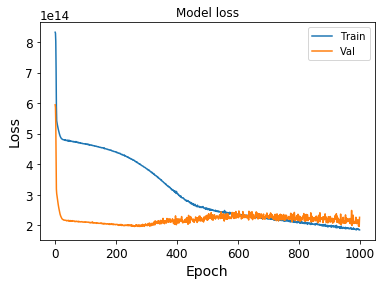

In [121]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

#### Deep Learning Model 2

In [160]:
model_2_mse = model_2.evaluate(X_test, Y_test)[0]
model_2_rmse = np.sqrt(model_2_mse)
reduced_num, ten_count = countTens(model_2_rmse)
print("RMSE on test set using Model 2 is: " + str(reduced_num) + " * 10^" + str(ten_count))

216/216 [==============================] - 0s 83us/sample - loss: 141226298135893.3438 - mean_squared_error: 141226292543488.0000
RMSE on test set using Model 2 is: 1.1883867137253485 * 10^7


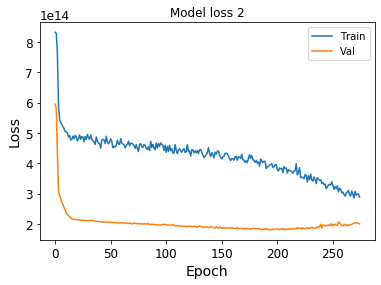

In [151]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# below figure doesn't show next 25 epochs. RMSE above was displayed after 25 more epoches (making total epochs = 300)

### Making Predictions on Validation Set & Custom Input

#### Linear Regression

In [165]:
price_predictions = lin_reg_model.predict(X_val)
lin_reg_mse = mean_squared_error(Y_val, price_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)

reduced_num, ten_count = countTens(lin_reg_rmse)
print("RMSE on validation set using Linear Regression is: " + str(reduced_num) + " * 10^" + str(ten_count))

RMSE on validation set using Linear Regression is: 1.0461315529577755 * 10^17


#### Decision Tree Regression

In [166]:
price_predictions = tree_reg_model.predict(X_val)
tree_reg_mse = mean_squared_error(price_predictions, Y_val)
tree_reg_rmse = np.sqrt(tree_reg_mse)
reduced_num, ten_count = countTens(tree_rmse)
print("RMSE on validation set using Decision Tree Regression is: " + str(reduced_num) + " * 10^" + str(ten_count))

RMSE on validation set using Decision Tree Regression is: 2.7435425654245926 * 10^7


#### Deep Learning Model 1

##### Predictions on Custom Input

In [ ]:
#test_data = np.array([1,7.624,33.669341,72.84489,1,1,0,0,0,1,1,1,1,1])
test_data = np.array([1 ,43.560, 33.669341, 72.84489, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1])
print(model_1.predict(test_data.reshape(1,14), batch_size=1))
prediction = model_1.predict(test_data.reshape(1,14), batch_size=1)
print(Y.at[1,"price"])
print(prediction - Y.at[1,"price"])

##### Predictions on Validation Set

In [163]:
pred_val = model_1.predict(X_val)
model1_val_rmse = np.sqrt(mean_squared_error(Y_val, pred_val))
reduced_num, ten_count = countTens(model1_val_rmse)
print("RMSE on validation set using model 1 is: " + str(reduced_num) + " * 10^" + str(ten_count))

RMSE on validation set using model 1 is: 1.5026939173212719 * 10^7


#### Deep Learning Model 2

##### Predictions on Custom Input

In [28]:
#test_data = np.array([1,7.624,33.669341,72.84489,1,1,0,0,0,1,1,1,1,1])
test_data = np.array([1 ,43.560, 33.669341, 72.84489, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1])
print(model_2.predict(test_data.reshape(1,14), batch_size=1))
prediction = model_2.predict(test_data.reshape(1,14), batch_size=1)
print(Y.at[1,"price"])
print(prediction - Y.at[1,"price"])

ValueError: Error when checking input: expected dense_5_input to have shape (475,) but got array with shape (14,)

##### Predictions on Training Set

In [164]:
pred_val = model_2.predict(X_val)
model2_val_rmse = np.sqrt(mean_squared_error(Y_val, pred_val))
reduced_num, ten_count = countTens(model2_val_rmse)
print("RMSE on validation set using model 2 is: " + str(reduced_num) + " * 10^" + str(ten_count))

RMSE on validation set using model 2 is: 1.424891094928326 * 10^7


## Conclusion

**Note:** DL models were not fine-tuned (by trying different hyper-parameters). Secondly, different configurations of DL models were not tried except for the given models.
- Model 2 showed the best results on the test and validation sets.
- **Future work** 
    - Work can be done on modifying the dataset according to the analysis given in this notebook. Suggested modifications can help in achieving better results in deep learning models. Because, most of suggestions are well-suited for the deep learning  models.
    - More deeper DL models can be tried, because moving from model 1 to model 2 showed some progress. Secondly, different layer configurations can be tried along with hyper-parameter tuning.



**In progress....*